### Read start_date and track_length from SMDB for all Missions and plot them over time

In [1]:
import json
import pandas as pd
import requests

# Get Mission data from smdb.shore.mbari.org's graphql REST api and put into dataframe

query = """query MyQuery {
  all_missions {
    name
    start_date
    track_length
  }
}"""

response = requests.post("https://smdb.shore.mbari.org/graphql", json={'query': query})
data = json.loads(response.text)
df = pd.json_normalize(data['data'], record_path=["all_missions"])
df["date"] = df["start_date"].astype("datetime64[ns]")
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
print(f"Number of Missions: {len(df)}")
df.dropna(inplace=True)
print(f"Number of Missions with navtracks and track_length: {len(df)}")
df

Number of Missions: 803
Number of Missions with navtracks and track_length: 766


,name,start_date,track_length
date,,,
2005-09-06 04:30:32.000000,MappingAUVOps2010/200509EndeavourABE,2005-09-06T04:30:32,313334.4
2006-02-21 18:12:04.874998,MappingAUVOps2006/20060221,2006-02-21T18:12:04.874998,12126.3
2006-02-22 17:49:57.625999,MappingAUVOps2006/20060222,2006-02-22T17:49:57.625999,13511.2
2006-03-21 23:43:20.441999,MappingAUVOps2006/20060321,2006-03-21T23:43:20.441999,1400.2
2006-03-22 18:08:03.718999,MappingAUVOps2006/20060322,2006-03-22T18:08:03.718999,19197.7
...,...,...,...
2021-09-08 15:10:18.600000,2021/20210908d1/multibeam,2021-09-08T15:10:18.600000,5261.9
2021-09-08 15:10:42.717000,2021/20210908d1/lidar,2021-09-08T15:10:42.717000,5278.4
2021-09-09 15:10:20.227998,2021/20210909d1/lidar,2021-09-09T15:10:20.227998,6552.0


In [2]:
from os.path import basename, dirname

def remove_duplicate_tracks(df: pd.DataFrame) -> pd.DataFrame:
    # Missions with names like 2021/20210910d1/lidar and 2021/20210910d1/multibeam
    # have the same nav_track and shouldn't be counted twice, remove all but one of them. 
    # See https://stackoverflow.com/a/47979665/1281657
    row_dict = {}
    for _, row in df.iterrows():
        leaf_dir = basename(row['name'])
        if leaf_dir.lower() == 'multibeam' or leaf_dir == 'lidar':
            # print(f"Renaming {row['name']} to {dirname(row['name'])}")
            row_dict[dirname(row['name'])] = ((row['start_date'], row['track_length']))
        elif 'sentry' in row['name'].lower():
            continue
        else:
            row_dict[row['name']] = ((row['start_date'], row['track_length'], ))
    row_list = []
    for key, value in row_dict.items():
        row_list.append({'name': key, 'start_date': value[0], 'track_length': value[1]})

    df_new = pd.DataFrame(row_list, columns=['name', 'start_date', 'track_length'])
    df_new["date"] = df_new["start_date"].astype("datetime64[ns]")
    df_new.set_index('date', inplace=True)
    df_new.drop('start_date', axis=1, inplace=True)
    df_new.sort_index(inplace=True)
    # Remove duplicated date indexes: https://stackoverflow.com/a/34297689/1281657
    df_new = df_new[~df_new.index.duplicated(keep='first')]
    df_new['track_length_cum_sum'] = df_new['track_length'].cumsum()

    return df_new

df = remove_duplicate_tracks(df)
print(f"Number of Missions after removing duplicate multibeam/lidar tracks: {len(df)}")
df

Number of Missions after removing duplicate multibeam/lidar tracks: 712


,name,track_length,track_length_cum_sum
date,,,
2005-09-06 04:30:32.000000,MappingAUVOps2010/200509EndeavourABE,313334.4,313334.4
2006-02-21 18:12:04.874998,MappingAUVOps2006/20060221,12126.3,325460.7
2006-02-22 17:49:57.625999,MappingAUVOps2006/20060222,13511.2,338971.9
2006-03-21 23:43:20.441999,MappingAUVOps2006/20060321,1400.2,340372.1
2006-03-22 18:08:03.718999,MappingAUVOps2006/20060322,19197.7,359569.8
...,...,...,...
2021-09-06 17:00:04.691998,2021/20210906d1/lidartest,151.8,40692212.3
2021-09-07 15:15:35.970999,2021/20210907d1,6996.6,40699208.9
2021-09-08 15:10:42.717000,2021/20210908d1,5278.4,40704487.3


<AxesSubplot:xlabel='date', ylabel='track_length_cum_sum (km)'>

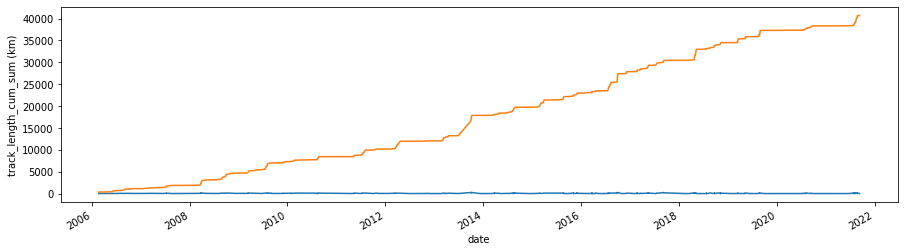

In [3]:
# Inspect and do some clean up

# Drop bad Arctic Mission: https://smdb.shore.mbari.org/missions/mappingauvops2013-20130928m1/
df.drop(df[df.name == 'MappingAUVOps2013/20130928m1'].index, inplace=True)

# Drop old big ABE mission: https://smdb.shore.mbari.org/missions/mappingauvops2010-200509endeavourabe/
df.drop(df[df.name == 'MappingAUVOps2010/200509EndeavourABE'].index, inplace=True)

df.loc[df['track_length'].idxmax()]
length_km = df['track_length'] / 1000.0
length_km_cum_sum = df['track_length_cum_sum'] / 1000.0
length_km.plot(ylabel="track_length (km)", figsize=(15,4))
length_km_cum_sum.plot(ylabel="track_length_cum_sum (km)", figsize=(15,4))